In [1]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
import pandas as pd

In [2]:
df_ccba = pd.read_csv("./訓練資料集_first/public_train_x_ccba_full_hashed.csv")
df_cdtx = pd.read_csv("./訓練資料集_first/public_train_x_cdtx0001_full_hashed.csv")
df_custinfo = pd.read_csv("./訓練資料集_first/public_train_x_custinfo_full_hashed.csv")
df_dp = pd.read_csv("./訓練資料集_first/public_train_x_dp_full_hashed.csv")
df_remit1 = pd.read_csv("./訓練資料集_first/public_train_x_remit1_full_hashed.csv")
df_alert_date = pd.read_csv("./訓練資料集_first/train_x_alert_date.csv")
df_public_alert_date = pd.read_csv("./訓練資料集_first/public_x_alert_date.csv")


In [3]:
train_data = df_alert_date.merge(df_custinfo, how= 'left', on = 'alert_key')
data = train_data.copy()
alert_times_dict = {}
alert_times_list = []
for i, row in train_data.iterrows():
    if alert_times_dict.__contains__(row.cust_id):
        alert_times_list.append(alert_times_dict[row.cust_id])
        alert_times_dict[row.cust_id] += 1
    else :
        alert_times_list.append(0)
        alert_times_dict[row.cust_id] = 1
train_data['alert_times'] = alert_times_list

In [4]:
return_key = list(data.columns)
data = data.merge(df_ccba, how = 'outer', left_on=['cust_id', 'date'], right_on=['cust_id', 'byymm'])
data['date'] = data[['date', 'byymm']].apply(lambda x : x[0] if pd.notna(x[0]) else x[1], axis = 1)
data.drop('byymm', axis = 1,inplace=True)
data = data.sort_values(['cust_id','alert_key']).reset_index(drop= True) # make cust info in the first of cust id to fill cust info
data.loc[:, data.columns!='alert_times'] = data.loc[:, data.columns!='alert_times'].fillna(method='ffill')
data.loc[:, data.columns!='alert_times'] = data.loc[:, data.columns!='alert_times'].fillna(method='bfill')
data = data.sort_values(['cust_id', 'date'])
data.fillna(method='ffill', inplace=True)
data.fillna(0, inplace=True)
train_data = train_data.merge(data, on = return_key, how = 'left')
data = train_data.copy()

In [5]:
df_cdtx['Isin_taiwan'] = df_cdtx['country'].map(lambda x : x == 130)
df_cdtx_intai = df_cdtx[df_cdtx['Isin_taiwan']]
df_cdtx_intai = df_cdtx_intai.rename({'amt' : 'amt_inside'}, axis = 1)
data = data.merge(df_cdtx_intai[['cust_id', 'date', 'amt_inside','country']], how = 'outer', on = ['cust_id', 'date'])
df_cdtx_notintai = df_cdtx[-df_cdtx['Isin_taiwan']]
df_cdtx_notintai = df_cdtx_notintai.rename({'amt' : 'amt_outside'}, axis = 1)
data = data.merge(df_cdtx_notintai[['cust_id', 'date', 'amt_outside','country']], how = 'outer', on = ['cust_id', 'date', 'country'])
data['country'] = data['country'].fillna(130)
data[["amt_inside", 'amt_outside']] = data[["amt_inside", 'amt_outside']].fillna(0)
data = data.groupby(['cust_id'], sort=False).apply(lambda x: x.ffill().bfill())
data = data.sort_values(['cust_id', 'date'])
data['country'] = data['country'].map(lambda x : str(int(x)))

In [7]:
df_answer = pd.read_csv("./訓練資料集_first/train_y_answer.csv")
train_data = train_data.merge(df_answer, how= 'left', on = 'alert_key')

In [37]:
train_data['occupation_code'] = train_data['occupation_code'].fillna(-1)
train_data[['lupay', 'cycam','usgam','clamt','csamt','inamt','cucsm','cucah']] = train_data[['lupay', 'cycam','usgam','clamt','csamt','inamt','cucsm','cucah']].fillna(0)

In [38]:
train_data = train_data.astype({
    'alert_key' : "category",
    'date' : "category",
    'cust_id' : "category", 
    'risk_rank': "category", 
    'occupation_code': "category",
    'total_asset' : "int32", 
    'AGE' : 'int32',
    'sar_flag': "category", 
    'alert_times': "category", 
    'lupay' : "int32", 
    'cycam' : "int32",
    'usgam' : "int32", 
    'clamt' : "int32", 
    'csamt' : "int32", 
    'inamt' : "int32", 
    'cucsm' : "int32", 
    'cucah' : "int32",
    # 'amt_outside' : "int32",
    # "amt_inside" : "int32",
    # "country" : 'category'
})

In [39]:
training_feature = [ 'risk_rank', 'occupation_code', 'total_asset', 'AGE', 'alert_times', 'lupay', 'cycam', 'usgam', 'clamt', 'csamt', 'inamt', 'cucsm', 'cucah']
X_train, X_test, y_train, y_test = train_test_split(train_data[training_feature], train_data['sar_flag'], test_size=0.3, random_state=1)

0.7056038399878578


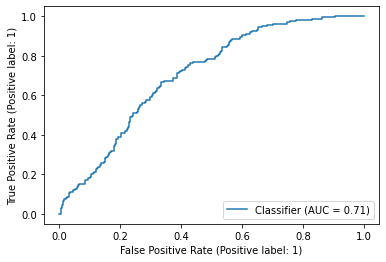

In [40]:
clf = LogisticRegression(solver="liblinear", random_state=0).fit(X_train, y_train)
print(roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))
RocCurveDisplay.from_predictions(y_train, clf.predict_proba(X_train)[:, 1])
plt.show()

0.6640026302193415


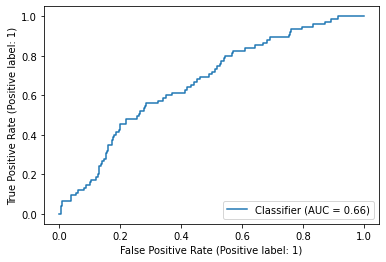

In [41]:
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
RocCurveDisplay.from_predictions(y_test, clf.predict_proba(X_test)[:, 1])
plt.show()

# Output

In [42]:
df_alert_date = pd.read_csv("./訓練資料集_first/public_x_alert_date.csv")
train_data = df_alert_date.merge(df_custinfo, how= 'left', on = 'alert_key')
data = train_data.copy()
alert_times_dict = {}
alert_times_list = []
for i, row in train_data.iterrows():
    if alert_times_dict.__contains__(row.cust_id):
        alert_times_list.append(alert_times_dict[row.cust_id])
        alert_times_dict[row.cust_id] += 1
    else :
        alert_times_list.append(0)
        alert_times_dict[row.cust_id] = 1
train_data['alert_times'] = alert_times_list

In [43]:
return_key = list(data.columns)
data = data.merge(df_ccba, how = 'outer', left_on=['cust_id', 'date'], right_on=['cust_id', 'byymm'])
data['date'] = data[['date', 'byymm']].apply(lambda x : x[0] if pd.notna(x[0]) else x[1], axis = 1)
data.drop('byymm', axis = 1,inplace=True)
data = data.sort_values(['cust_id','alert_key']).reset_index(drop= True) # make cust info in the first of cust id to fill cust info
data.loc[:, data.columns!='alert_times'] = data.loc[:, data.columns!='alert_times'].fillna(method='ffill')
data.loc[:, data.columns!='alert_times'] = data.loc[:, data.columns!='alert_times'].fillna(method='bfill')
data = data.sort_values(['cust_id', 'date'])
data.fillna(method='ffill', inplace=True)
data.fillna(0, inplace=True)
train_data = train_data.merge(data, on = return_key, how = 'left')
data = train_data.copy()

In [48]:
df_sample = pd.read_csv('./訓練資料集_first/預測的案件名單及提交檔案範例.csv')
train_data['probability'] = clf.predict_proba(train_data[training_feature])[:,-1]
data_output = df_alert_date.merge(train_data, how = 'left', on = ['alert_key', 'date'])
data_output = data_output[['alert_key', 'probability']].drop_duplicates(subset='alert_key').reset_index(drop= True)
data_output = df_sample.merge(data_output, how='left', on = 'alert_key').fillna(0)[['alert_key', 'probability_y']]
data_output = data_output.rename({'probability_y' : 'probability'},axis = 1)
data_output

,alert_key,probability
0,357307,0.127817
1,376329,0.000000
2,373644,0.000000
3,357668,0.004434
4,354443,0.118183
...,...,...
3845,364485,0.010657
3846,363155,0.000614
3847,368710,0.000000
3848,358067,0.016068


In [46]:
df_sample

,alert_key,probability
0,357307,0.000017
1,376329,0.000324
2,373644,0.000372
3,357668,0.000489
4,354443,0.000526
...,...,...
3845,364485,0.997702
3846,363155,0.998987
3847,368710,0.999694
3848,358067,0.999821


In [50]:
data_output[['alert_key', 'probability']].to_csv('./output/output1206.csv',index = False)